In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sympy

from scipy.integrate import odeint, solve_ivp
from scipy.stats import linregress
from scipy.optimize import curve_fit
from sympy import lambdify, Matrix, symbols, Symbol, Eq
from sympy.solvers.ode.systems import dsolve_system
from sympy import vector, solve
from typing import Tuple
from cycler import cycler
from collections import defaultdict

plt.style.use('style.mpl')

# Gaining intuition about cofactors and pathway kinetics

The goal here is to understand how the presence of co-factors, which participate in multiple reactions, affect the kinetics of pathways. Here we consider a linear cascade with 4 reaction steps where the cofactor participates in the two internal steps

$M_0 \leftrightarrow M_1 + M_f \leftrightarrow M_2 + M_f \leftrightarrow M_3 \leftrightarrow M_4$ 

Where $M_f$ denotes the shared co-factor whose concentration is assumed to be fixed by cellular homeostasis. We aim to understand how the presence of a cofactor affects the coarse-grained representation of a pathway -- i.e. a chain or enzymatic rate laws -- as a single effective enzyme with effective kinetic parameters. 

Some summary results:
* Of course the saturation state w.r.t. the cofactor matters.
    * the presence of the co-factor can only decrease the the total pathway flux compared to an equivalent pathway without cofactors. 
* In the linear regime, pathway flux scales with cofactor^1, not cofactor^2, even though the net reaction consumes 2 cofactor per substrate. Not sure I understand why this is.


In [2]:
def _MM(x,kcat,KM):
    return kcat*x/(KM+x)

def fit_MM(concentrations, rates):
    """Fit Michaelis-Menten kinetics to data.
    
    Returns:
        2-tuple of floats: kcat, KM
    """
    ret = curve_fit(_MM, concentrations, rates, p0=[1,1])
    return ret[0]

In [3]:
# stoichiometric matrix -- metabolites on rows, reactions on columns
# the last metabolite is a co-factor like NADH that is used in multiple reactions
S = [
    [-1, 0, 0, 0],  # R_0 converts 1 M_0 to 1 M_1
    [1, -1, 0, 0],  # R_1 converts 1 M_1 to 1 M_2
    [0, 1, -1, 0],  # R_2 converts 1 M_2 to 1 M_3
    [0, 0, 1, 0],   # R_3 converts 1 M_3 to 1 M_4
    [0, -2, -1, 0]  # cofactor consumed in R_1 and R_2
]
S = np.array(S)

display(S)

array([[-1,  0,  0,  0],
       [ 1, -1,  0,  0],
       [ 0,  1, -1,  0],
       [ 0,  0,  1,  0],
       [ 0, -2, -1,  0]])

In [4]:
# Total enzyme abundances.
Es = E_0, E_1, E_2, E_3 = sympy.symbols("E_0 E_1 E_2, E_3") 

# Catalytic rates
kplus = kp_0, kp_1, kp_2, kp_3 = sympy.symbols("kp_0 kp_1 kp_2 kp_3")

# half-saturation constants -- cofactor has same KM for all reactions
KMf = KMf_0, KMf_1, KMf_2, KMf_3, KM_F = sympy.symbols("KMf_0 KMf_1 KMf_2 KMf_2 KM_F")

# Metabolite concentrations
Cs = C_0, C_1, C_2, C_3, C_4, C_F = sympy.symbols("C_0 C_1 C_2 C_3 C_4 C_F") 

# initial concs are 0 unless otherwise stated
# in practice will fix C_0 at some value in the dynamical equations
initial_concentrations = defaultdict(float)

# time 
t = sympy.symbols("t")

# Arrays for symbolic math
Es_array = np.array(Es) 
Cs_array = np.array(Cs)
kp_array = np.array(kplus)
KMf_array = np.array(KMf)
subs_array = np.array(Cs[:-1])
prods_array = np.array(Cs[1:])

# Concentration dynamics for irreversible MM kinetics
# Tried to do this with matrices but it's complicated
CF_SAT = (KM_F + C_F)
eqs = [
    -kp_0*C_0*E_0/(KMf_0 + C_0), # d C_0 / dt
    kp_0*C_0*E_0/(KMf_0 + C_0) - kp_1*C_1*C_F*E_1/((KMf_1 + C_1)*CF_SAT), # d C_1 / dt
    #kp_0*C_0*E_0/(KMf_0 + C_0) - kp_1*C_1*C_F*C_F*E_1/((KMf_1 + C_1)*CF_SAT*CF_SAT), # d C_1 / dt
    kp_1*C_1*C_F*E_1/((KMf_1 + C_1)*CF_SAT) - kp_2*C_2*C_F*E_2/((KMf_2 + C_2)*CF_SAT), # d C_2 / dt
    #kp_1*C_1*C_F*C_F*E_1/((KMf_1 + C_1)*CF_SAT*CF_SAT) - kp_2*C_2*C_F*E_2/((KMf_2 + C_2)*CF_SAT), # d C_2 / dt
    kp_2*C_2*C_F*E_2/((KMf_2 + C_2)*CF_SAT) - kp_3*C_3*E_3/(KMf_3 + C_3), # d C_3 / dt
    kp_3*C_3*E_3/(KMf_3 + C_3), # d C_4 / dt
    -kp_1*C_1*C_F*E_1/((KMf_1 + C_1)*CF_SAT) - kp_2*C_2*C_F*E_2/((KMf_2 + C_2)*CF_SAT) # d COFACTOR / dt
    #-2*kp_1*C_1*C_F*C_F*E_1/((KMf_1 + C_1)*CF_SAT*CF_SAT) - kp_2*C_2*C_F*E_2/((KMf_2 + C_2)*CF_SAT) # d COFACTOR / dt
]

# Show the equations in a nice format.
dy_dt = sympy.Matrix(eqs, ndmin=1)
symbolic_dy_dt = sympy.Matrix([sympy.Derivative(symb, t) for symb in Cs], ndmin=1)
display(sympy.Eq(symbolic_dy_dt, dy_dt))

Eq(Matrix([
[Derivative(C_0, t)],
[Derivative(C_1, t)],
[Derivative(C_2, t)],
[Derivative(C_3, t)],
[Derivative(C_4, t)],
[Derivative(C_F, t)]]), Matrix([
[                                                                   -C_0*E_0*kp_0/(C_0 + KMf_0)],
[                    C_0*E_0*kp_0/(C_0 + KMf_0) - C_1*C_F*E_1*kp_1/((C_1 + KMf_1)*(C_F + KM_F))],
[ C_1*C_F*E_1*kp_1/((C_1 + KMf_1)*(C_F + KM_F)) - C_2*C_F*E_2*kp_2/((C_2 + KMf_2)*(C_F + KM_F))],
[                    C_2*C_F*E_2*kp_2/((C_2 + KMf_2)*(C_F + KM_F)) - C_3*E_3*kp_3/(C_3 + KMf_2)],
[                                                                    C_3*E_3*kp_3/(C_3 + KMf_2)],
[-C_1*C_F*E_1*kp_1/((C_1 + KMf_1)*(C_F + KM_F)) - C_2*C_F*E_2*kp_2/((C_2 + KMf_2)*(C_F + KM_F))]]))

In [5]:
# Helper to do the translation from sympy to odeint
def integrate(ys: list, 
              dy_dt: sympy.Matrix,
              initial_concs: dict,
              max_t: float) -> Tuple[np.ndarray, np.ndarray]:
    J_func = sympy.lambdify((ys, t), dy_dt)
    J2_func = lambda y, t: J_func(y, t).flatten()

    tout = np.linspace(0, max_t, 10000)
    y_init = [initial_concs[symb] for symb in ys]
    
    y_odeint = odeint(J2_func, y_init, tout)
    return tout, y_odeint

In [6]:
# Considering the case where all pathway steps are irreversible, and have the
# same kinetic parameters. 
subs_irr = dict(E_0=1, E_1=1, E_2=1, E_3=1,
                kp_0=1, kp_1=1, kp_2=1, kp_3=1,
                KMf_0=1, KMf_1=1, KMf_2=1, KMf_3=1, KM_F=1)
irreversible_dynamics = Matrix(dy_dt, ndim=1).subs(subs_irr)

print('irreversible_dynamics')
display(irreversible_dynamics)


irreversible_dynamics


Matrix([
[                                                -C_0/(C_0 + 1)],
[                 C_0/(C_0 + 1) - C_1*C_F/((C_1 + 1)*(C_F + 1))],
[ C_1*C_F/((C_1 + 1)*(C_F + 1)) - C_2*C_F/((C_2 + 1)*(C_F + 1))],
[                 C_2*C_F/((C_2 + 1)*(C_F + 1)) - C_3/(C_3 + 1)],
[                                                 C_3/(C_3 + 1)],
[-C_1*C_F/((C_1 + 1)*(C_F + 1)) - C_2*C_F/((C_2 + 1)*(C_F + 1))]])

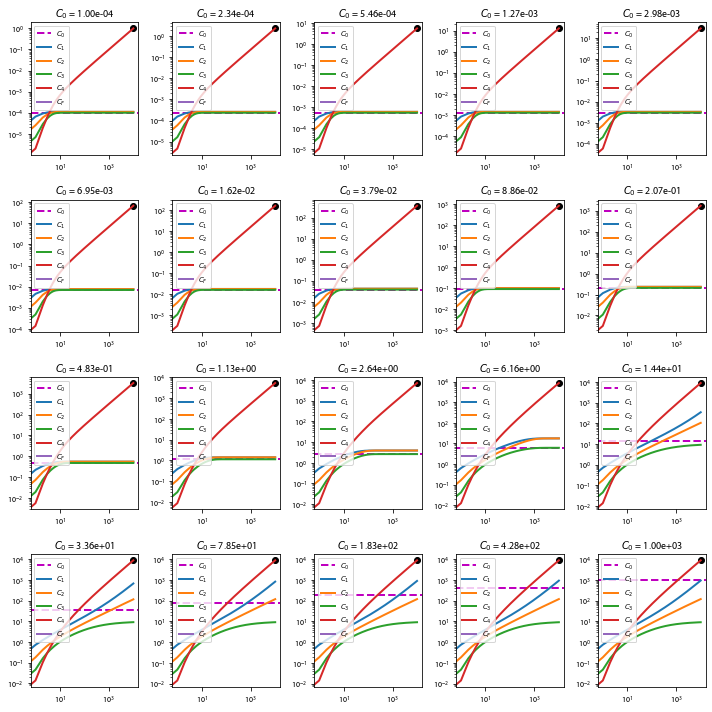

In [7]:
# Simulate the dynamics of the irreversible pathway
# as a function of substrate concentration. 
fig, axs = plt.subplots(4, 5, figsize=(10, 10))
flat_axs = axs.flatten()

c_0_conc = np.logspace(-4, 3, 20)
out_rates = []
my_dynamics = irreversible_dynamics
for c, ax in zip(c_0_conc, flat_axs):
    # Fix the concentration of C_0 to c, C_F to 1.
    # C_F = 10 means ~saturation for the cofactor.
    tout, y_odeint = integrate(Cs, my_dynamics.subs({C_0: c, C_F: 10}),
                               initial_concentrations, 10000)
    
    # Get concentrations near the end of the simulation to treat as steady state.
    cvals_ss = dict(zip(Cs, y_odeint[-2, :]))
    # Calcualte the rate of production of the product, C_4, which is 2nd-to-last before cofactor.
    prod_rate = my_dynamics[-2].subs(cvals_ss)
    out_rates.append(prod_rate)

    plt.sca(ax)
    plt.axhline(c, linestyle="--", color="m")
    plt.loglog(tout, y_odeint[:,1:])
    plt.scatter(tout[-2], y_odeint[:,-2][-2], color="k")
    plt.legend([f"${sympy.latex(symb)}$" for symb in Cs])
    plt.title("$C_0$ = {:.2e}".format(c))

plt.tight_layout()
plt.show()

fit kcat: 0.98, fit KM: 0.94


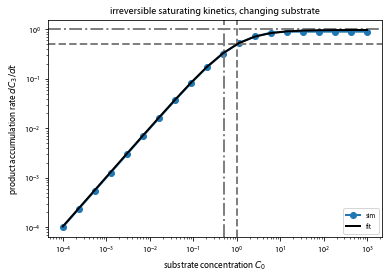

In [8]:
# Each pathway step has kcat 1.0 and a KM of 1.0 line each step.
plt.figure()
plt.loglog(c_0_conc, out_rates, "o-", label='sim')

# nominal kcat is 1.0, but actually 0.5 due to cofactor being at half-sat. 
plt.axhline(1, linestyle="-.", color="grey")
plt.axhline(1/2, linestyle="--", color="grey")

# nominal KM is 1.0
plt.axvline(1, linestyle="--", color="grey")
# effective KM is ~1/2 due to reduced max rate
plt.axvline(1/2, linestyle="-.", color="grey")

fit_kcat, fit_KM = fit_MM(c_0_conc[5:-5], out_rates[5:-5])
print("fit kcat: {:.2f}, fit KM: {:.2f}".format(fit_kcat, fit_KM))

plt.plot(c_0_conc, _MM(c_0_conc, fit_kcat, fit_KM), "k-", label='fit')

plt.legend()
plt.title('irreversible saturating kinetics, changing substrate')
plt.xlabel("substrate concentration $C_0$")
plt.ylabel("product accumulation rate $dC_3/dt$")
plt.show()

Simulate the pathway dynamics as a function of cofactor concentration.

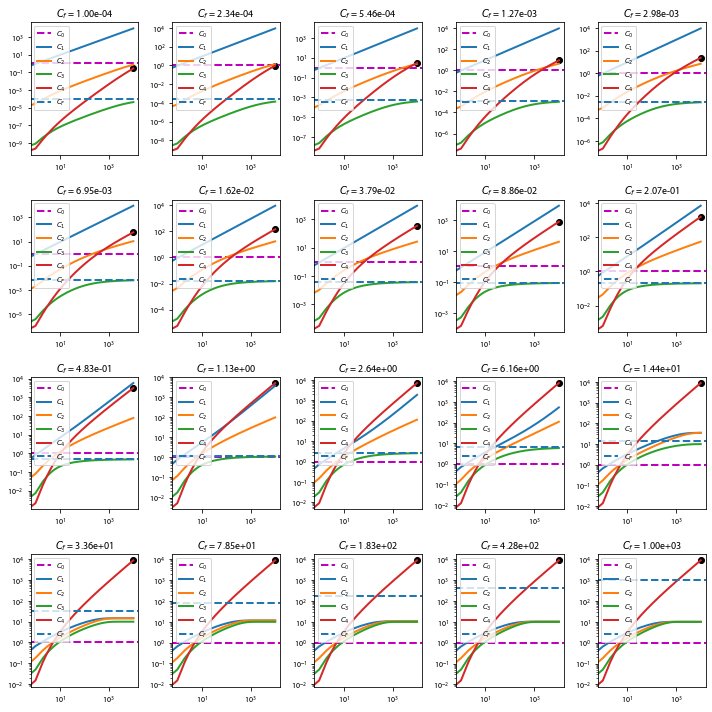

In [9]:
# Simulate the dynamics of the irreversible pathway
# as a function of cofactor concentration.
fig, axs = plt.subplots(4, 5, figsize=(10, 10))
flat_axs = axs.flatten()

c_f_conc = np.logspace(-4, 3, 20)
out_rates = []
my_dynamics = irreversible_dynamics
for c, ax in zip(c_f_conc, flat_axs):
    # Fix the concentration of C_0 to c, C_F to 1.
    # C_F = 1 means half-saturation for the cofactor.
    tout, y_odeint = integrate(Cs, my_dynamics.subs({C_0: 10, C_F: c}),
                               initial_concentrations, 10000)
    
    # Get concentrations near the end of the simulation to treat as steady state.
    cvals_ss = dict(zip(Cs, y_odeint[-2, :]))
    # Calcualte the rate of production of the product, C_4, which is 2nd-to-last before cofactor.
    prod_rate = my_dynamics[-2].subs(cvals_ss)
    out_rates.append(prod_rate)

    plt.sca(ax)
    plt.axhline(1, linestyle="--", color="m")
    plt.loglog(tout, y_odeint[:,1:-1])
    plt.axhline(c, linestyle="--")
    
    plt.scatter(tout[-2], y_odeint[:,-2][-2], color="k")
    plt.legend([f"${sympy.latex(symb)}$" for symb in Cs])
    plt.title("$C_f$ = {:.2e}".format(c))

plt.tight_layout()
plt.show()

cofactor exp: 3.15, prefactor: 1.91
fit kcat: 0.98, fit KM: 0.98


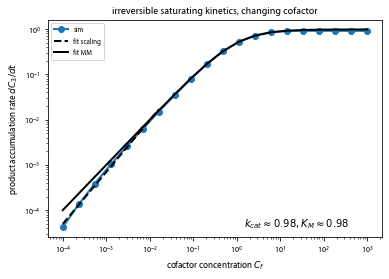

In [10]:
# Each pathway step has kcat 1.0 and a KM of 1.0 line each step.
plt.figure()
plt.loglog(c_f_conc, out_rates, "o-", label='sim')

# nominal kcat is 1.0, but actually 0.5 due to cofactor being at half-sat. 
#plt.axhline(1, linestyle="-.", color="grey")
#plt.axhline(1/2, linestyle="--", color="grey")

# nominal KM is 1.0
#plt.axvline(1, linestyle="--", color="grey")
# effective KM is ~1/2 due to reduced max rate
#plt.axvline(1/2, linestyle="-.", color="grey")

# linear fit of logged values to see the scaling of rate
# with cofactor concentration in the linear regime
fit_xs = np.log(c_f_conc[:7])
fit_ys = np.log(np.array(out_rates[:7]).astype(float))

slope, intercept, r_value, p_value, std_err = linregress(fit_xs, fit_ys)
plt.plot(np.exp(fit_xs), np.exp(intercept + slope*fit_xs), "k--", label='fit scaling')
print("cofactor exp: {:.2f}, prefactor: {:.2f}".format(np.exp(slope), np.exp(intercept)))

fit_kcat, fit_KM = fit_MM(c_f_conc[5:-5], out_rates[5:-5])
print("fit kcat: {:.2f}, fit KM: {:.2f}".format(fit_kcat, fit_KM))

plt.text(0.9, 0.05, "$k_{{cat}} \\approx {:.2f}, K_M \\approx {:.2f}$".format(fit_kcat, fit_KM),
            transform=plt.gca().transAxes, ha='right')
plt.plot(c_0_conc, _MM(c_0_conc, fit_kcat, fit_KM), "k-", label='fit MM')

plt.legend()
plt.title('irreversible saturating kinetics, changing cofactor')
plt.xlabel("cofactor concentration $C_f$")
plt.ylabel("product accumulation rate $dC_3/dt$")
plt.show()

In [11]:
np.log(out_rates)

TypeError: loop of ufunc does not support argument 0 of type Float which has no callable log method

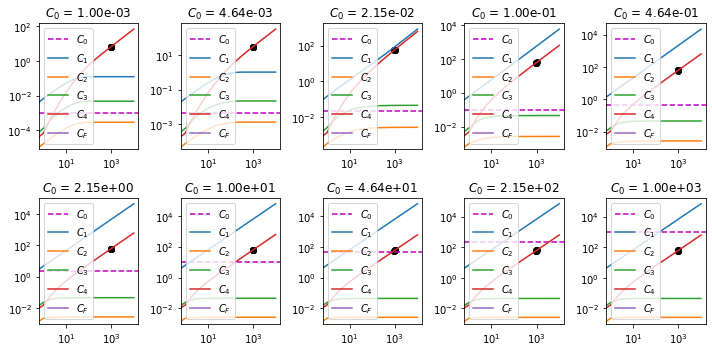

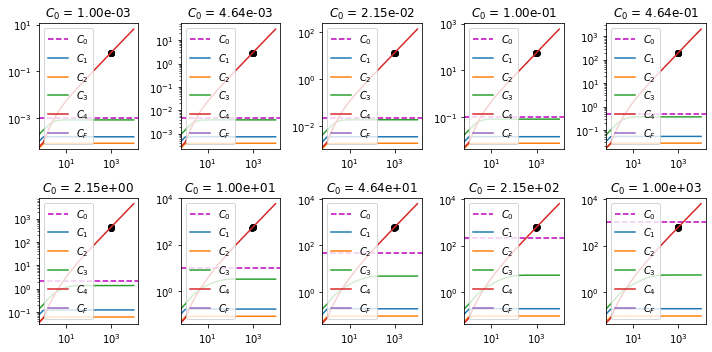

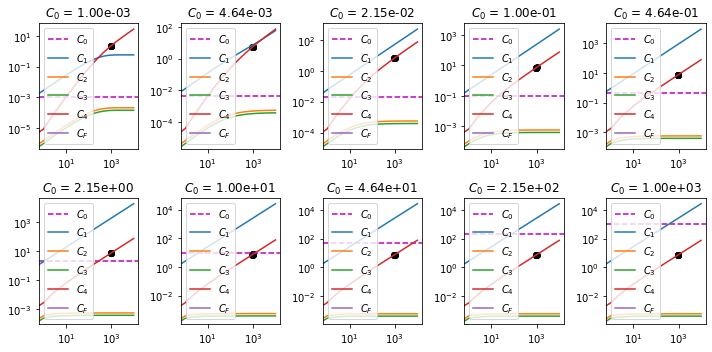

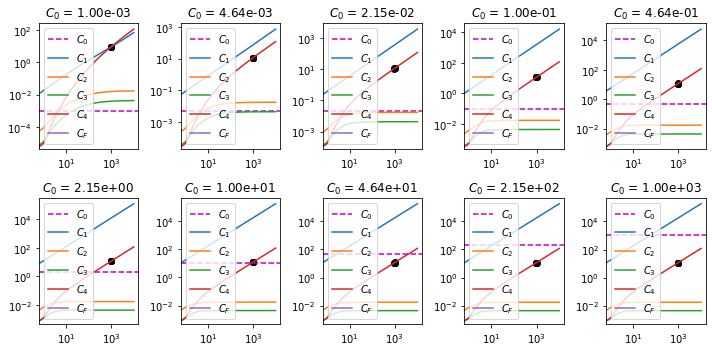

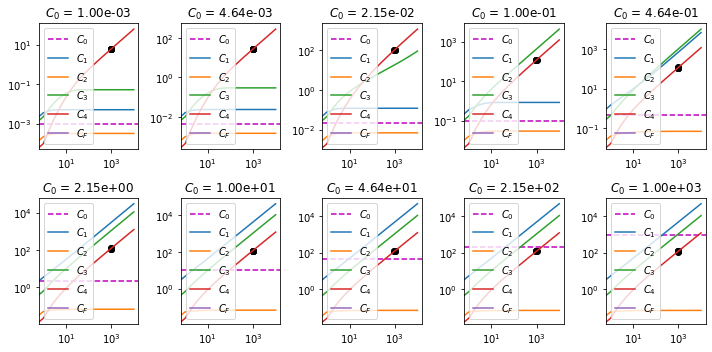

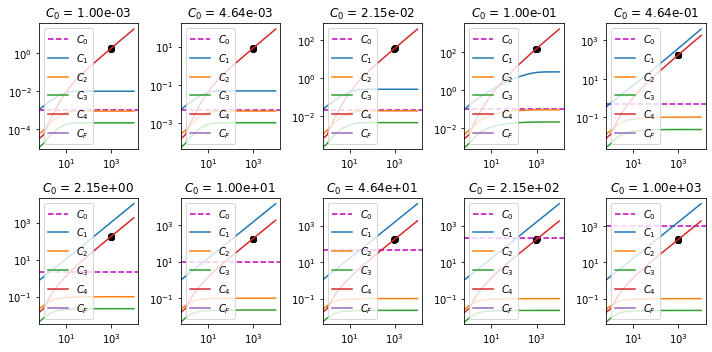

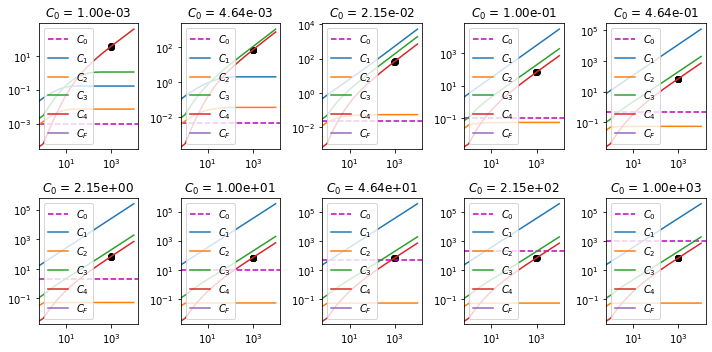

KeyboardInterrupt: 

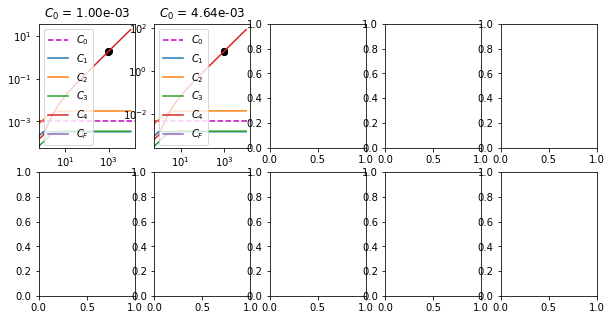

In [ ]:
# Now we will sample forward kcat values from a lognormal distribution and
# simulate as a function of C_0 to see what pathway kcat looks like. 

# Make this reproducible randomization
np.random.seed(1234)

c_0_conc = np.logspace(-3, 3, 10)
sampled_kps = np.zeros((10, 4))
out_rates = np.zeros((10, 10))

for i in range(10):
    # Randomize the catalytic rates of each step, lognormal dist.
    rand_kps = np.random.lognormal(mean=1, sigma=2, size=4)
    sampled_kps[i, :] = rand_kps
    my_subs = subs_irr.copy()
    my_subs.update(dict(kp_0=rand_kps[0], kp_1=rand_kps[1], kp_2=rand_kps[2], kp_3=rand_kps[3]))
    my_dynamics = Matrix(dy_dt, ndim=1).subs(my_subs)

    fig, axs = plt.subplots(2, 5, figsize=(10, 5))
    flat_axs = axs.flatten()
    for j, (c, ax) in enumerate(zip(c_0_conc, flat_axs)):
        # Fix the concentration of C_0 to c.
        tout, y_odeint = integrate(Cs, my_dynamics.subs({C_0: c, C_F: 1}),
                                   initial_concentrations, 10000)
        
        # Get concentrations near the end of the simulation to treat as steady state.
        cvals_ss = dict(zip(Cs, y_odeint[-2, :]))
        # Calcualte the rate of production of the product, C_3.
        prod_rate = my_dynamics[-2].subs(cvals_ss)
        out_rates[i, j] = prod_rate

        plt.sca(ax)
        plt.axhline(c, linestyle="--", color="m")
        plt.loglog(tout, y_odeint[:,1:])
        idxs = np.arange(950, 1000, 10)
        plt.scatter(tout[idxs], y_odeint[:,-2][idxs], color="k")
        plt.legend([f"${sympy.latex(symb)}$" for symb in Cs])
        plt.title("$C_0$ = {:.2e}".format(c))
        
    plt.tight_layout()
    plt.show()

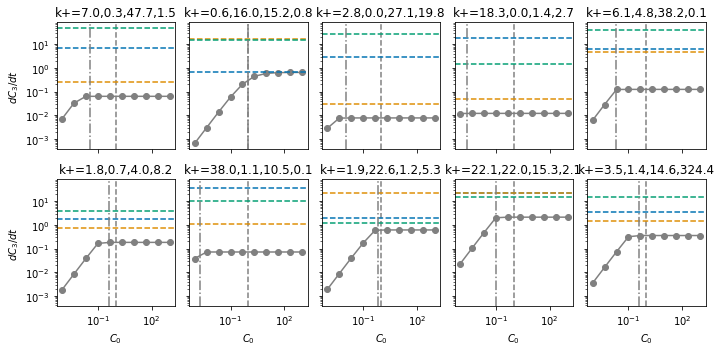

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5), sharex=True, sharey=True)
flat_axs = axs.flatten()

pal = sns.color_palette("colorblind", 3)
for i in range(10):
    plt.sca(flat_axs[i])
    plt.loglog(c_0_conc, out_rates[i, :], "o-", color='grey')

    plt.axvline(1, ls='--', color='grey')    
    for j in range(3):
        plt.axhline(sampled_kps[i,j], ls='--', color=pal[j])

    min_kp = np.min(sampled_kps[i, :])
    rescaled_KM = 1*min_kp/sampled_kps[i, 0] 
    plt.axvline(rescaled_KM, ls='-.', color='grey')

    plt.title("k+={:.1f},{:.1f},{:.1f},{:.1f}".format(*sampled_kps[i, :]))

for a in axs[1,:]:
    plt.sca(a)
    plt.xlabel("$C_0$")

for a in axs[:,0]:
    plt.sca(a)
    plt.ylabel("$d C_3 / dt$")

plt.tight_layout()
plt.show()

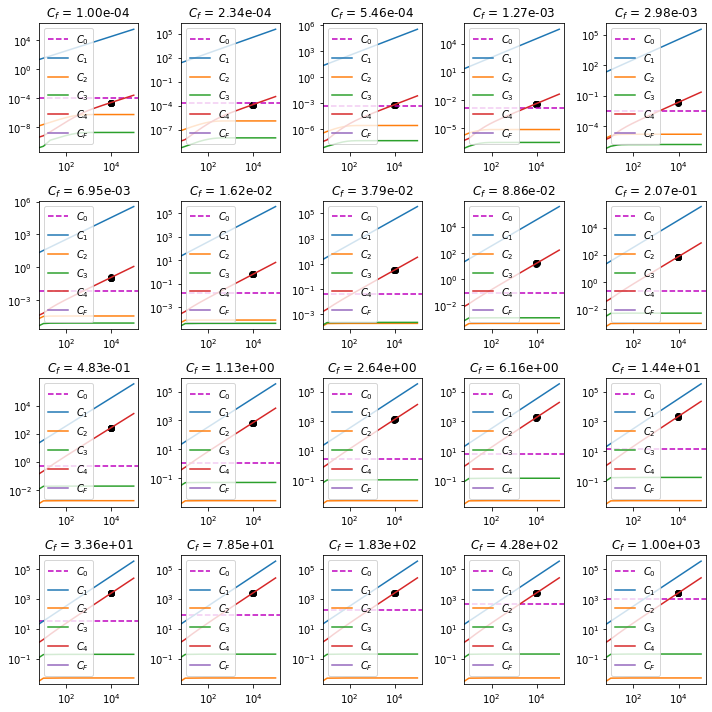

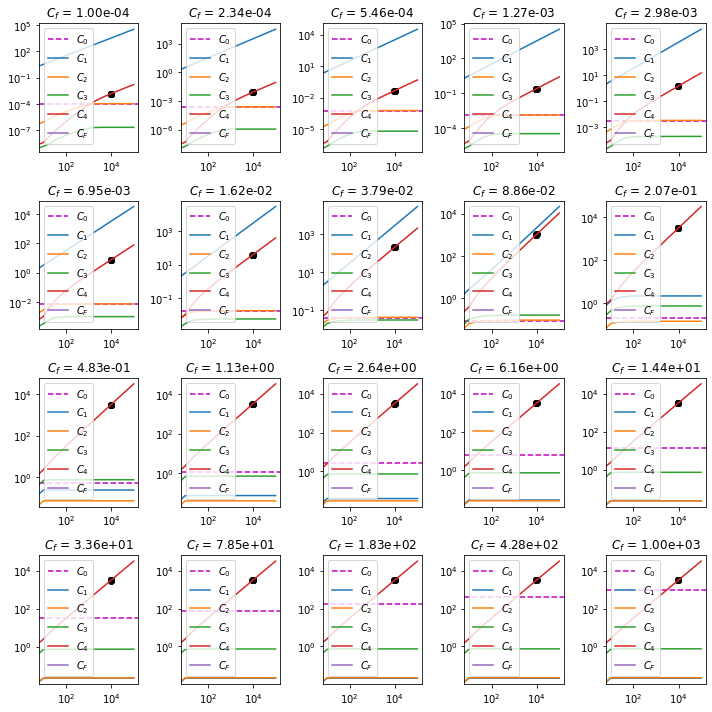

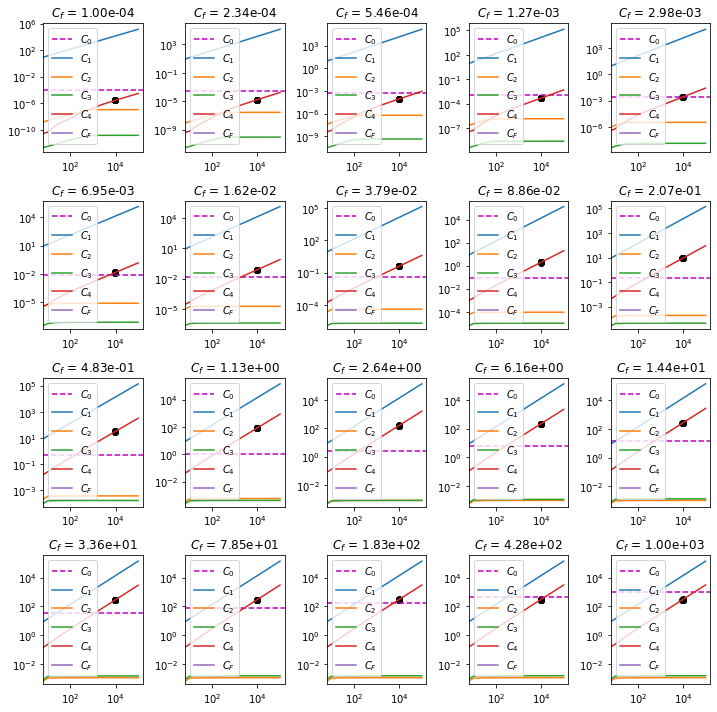

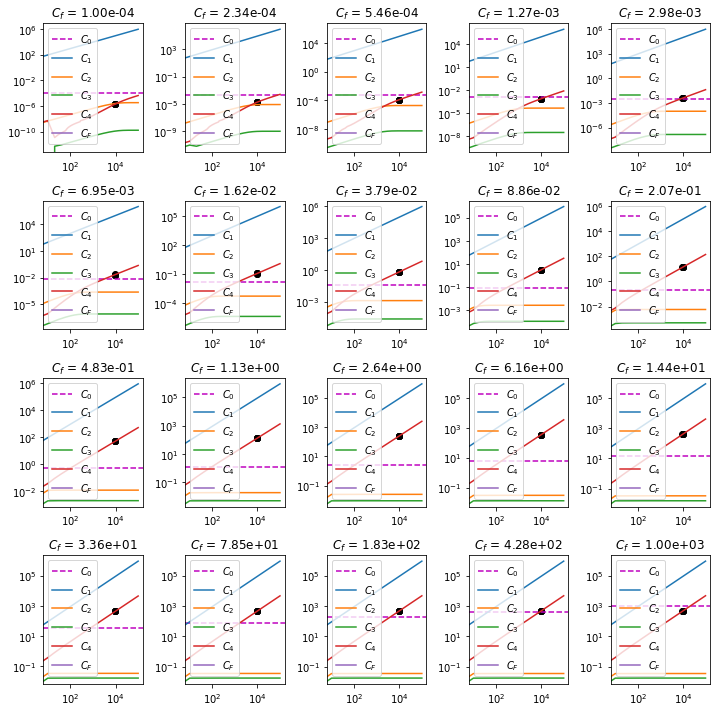

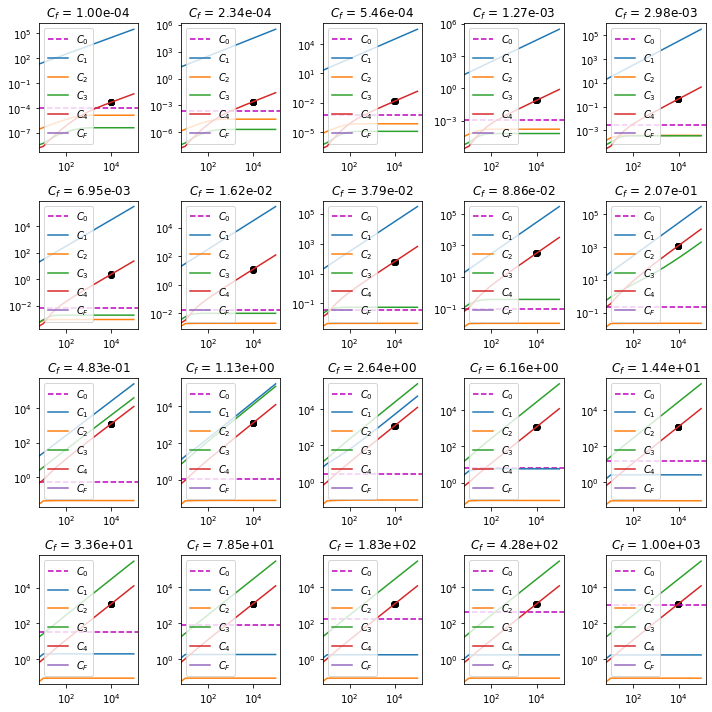

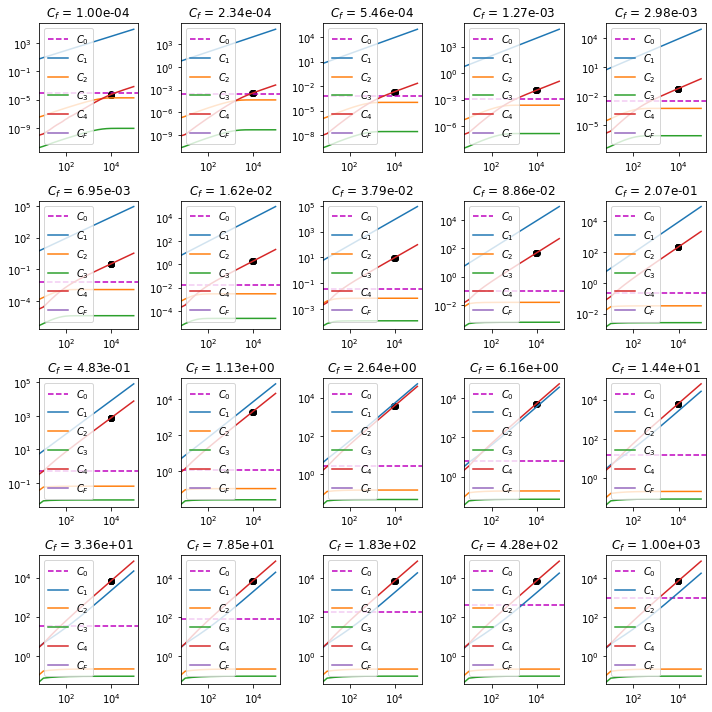

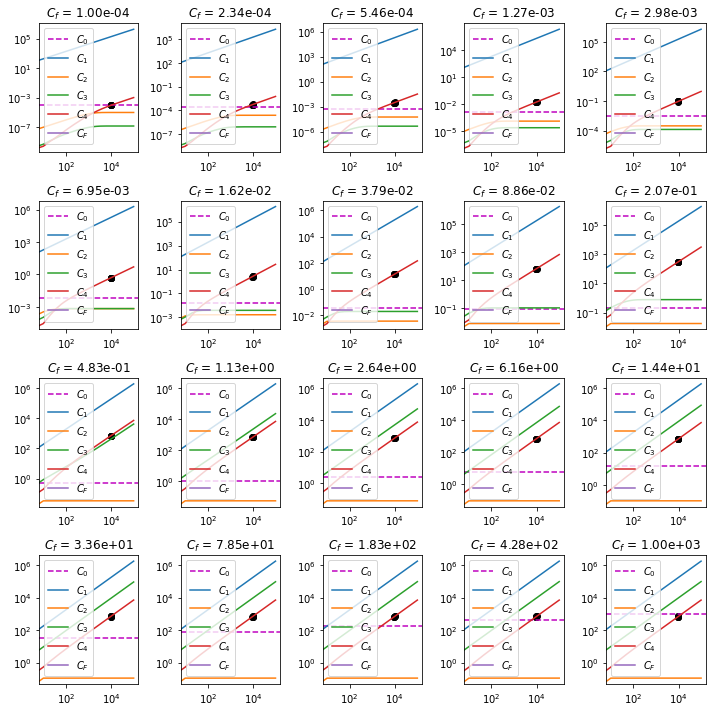

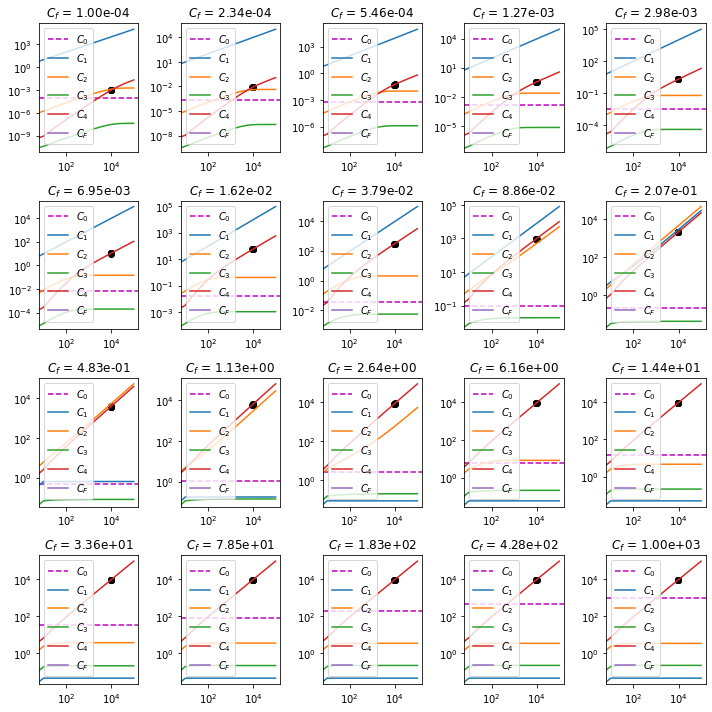

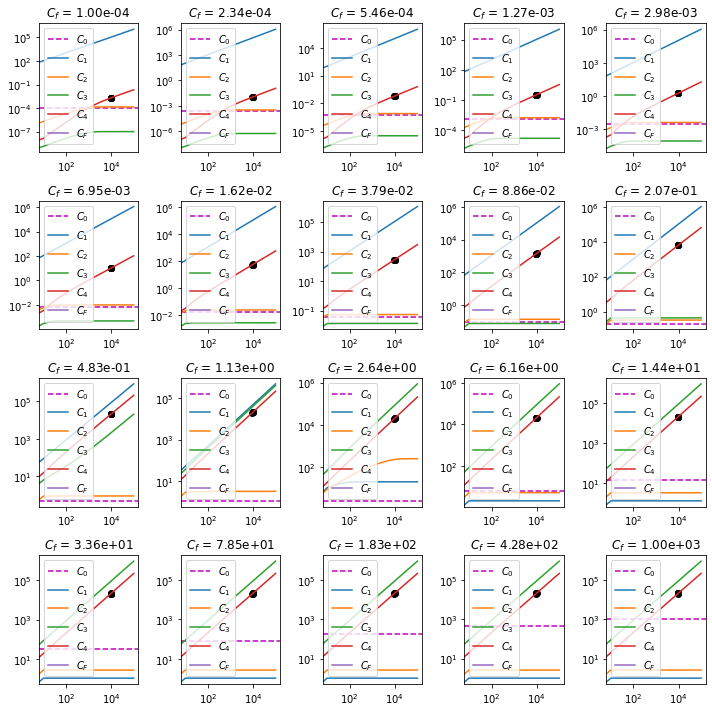

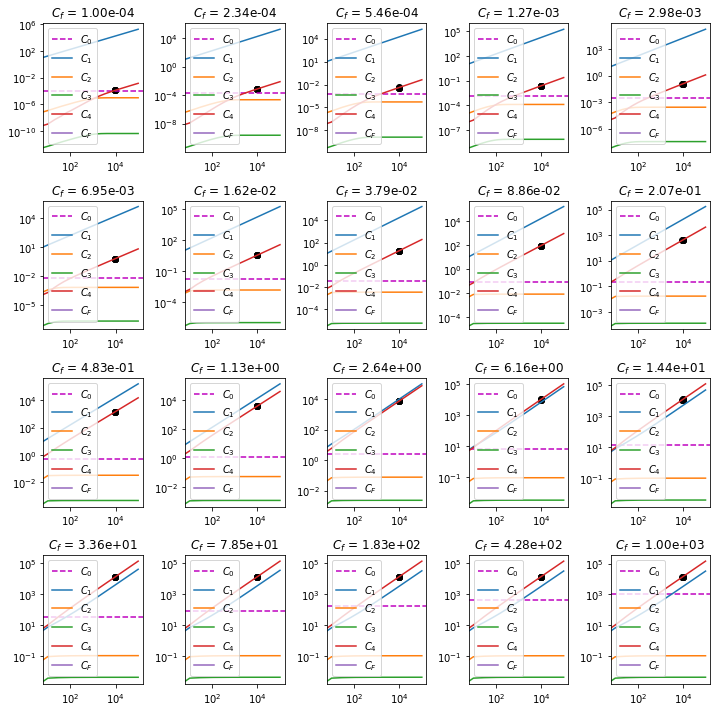

In [ ]:
# Now we will simulate as a function of cofactor concentration.
# The goal here is to see how the pathway flux scales with cofactor concentration
# in the linear regime.

# Make this reproducible randomization
np.random.seed(1234)

c_f_conc = np.logspace(-4, 3, 20)
sampled_kps = np.zeros((10, 4))
out_rates = np.zeros((10, 20))

for i in range(10):
    # Randomize the catalytic rates of each step, lognormal dist.
    rand_kps = np.random.lognormal(mean=1, sigma=2, size=4)
    sampled_kps[i, :] = rand_kps
    my_subs = subs_irr.copy()
    my_subs.update(dict(kp_0=rand_kps[0], kp_1=rand_kps[1], kp_2=rand_kps[2], kp_3=rand_kps[3]))
    my_dynamics = Matrix(dy_dt, ndim=1).subs(my_subs)

    fig, axs = plt.subplots(4, 5, figsize=(10, 10))
    flat_axs = axs.flatten()
    for j, (c, ax) in enumerate(zip(c_f_conc, flat_axs)):
        # Fix the concentration of C_f to 1 (half-saturation) and vary C_F.
        tout, y_odeint = integrate(Cs, my_dynamics.subs({C_0: 1, C_F: c}),
                                   initial_concentrations, 100000)
        
        # Get concentrations near the end of the simulation to treat as steady state.
        # Note the last concentration is the cofactor, so -2 is the product.
        cvals_ss = dict(zip(Cs, y_odeint[-2, :]))
        # Calculate the rate of production of the product, C_4.
        prod_rate = my_dynamics[-2].subs(cvals_ss)
        out_rates[i, j] = prod_rate

        plt.sca(ax)
        plt.axhline(c, linestyle="--", color="m")
        plt.loglog(tout, y_odeint[:,1:])
        idxs = np.arange(950, 1000, 10)
        plt.scatter(tout[idxs], y_odeint[:,-2][idxs], color="k")
        plt.legend([f"${sympy.latex(symb)}$" for symb in Cs])
        plt.title("$C_f$ = {:.2e}".format(c))
        
    plt.tight_layout()
    plt.show()

fit kcat/KM = 0.25
scaling exp (cofactor^exp) = 2.00
fit kcat/KM = 15.95
scaling exp (cofactor^exp) = 2.00
fit kcat/KM = 0.03
scaling exp (cofactor^exp) = 2.00
fit kcat/KM = 0.05
scaling exp (cofactor^exp) = 2.00
fit kcat/KM = 4.82
scaling exp (cofactor^exp) = 2.00
fit kcat/KM = 0.73
scaling exp (cofactor^exp) = 2.00
fit kcat/KM = 1.06
scaling exp (cofactor^exp) = 2.00
fit kcat/KM = 22.49
scaling exp (cofactor^exp) = 2.00
fit kcat/KM = 21.91
scaling exp (cofactor^exp) = 2.00
fit kcat/KM = 1.42
scaling exp (cofactor^exp) = 2.00


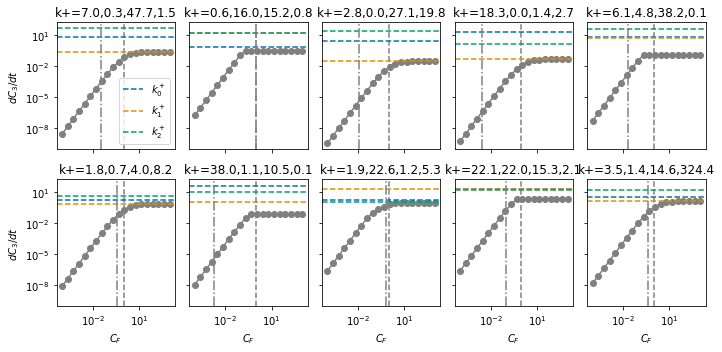

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5), sharex=True, sharey=True)
flat_axs = axs.flatten()

pal = sns.color_palette("colorblind", 3)
for i in range(10):
    plt.sca(flat_axs[i])
    plt.loglog(c_f_conc, out_rates[i, :], "o-", color='grey')

    # Fit the linear regime (first 3 points) to get effective kcat/KM
    fit_ys = np.log(out_rates[i, :3])
    fit_xs = np.log(c_f_conc[:3])
    res = linregress(fit_xs, fit_ys)
    print('fit kcat/KM = {0:.2f}'.format(np.exp(res.intercept)))
    print('scaling exp (cofactor^exp) = {0:.2f}'.format(res.slope))

    plt.axvline(1, ls='--', color='grey')    
    for j in range(3):
        plt.axhline(sampled_kps[i,j], ls='--', color=pal[j], label='$k^+_{0}$'.format(j))

    min_kp = np.min(sampled_kps[i, :])
    rescaled_KM = 1*min_kp/sampled_kps[i, 0] 
    plt.axvline(rescaled_KM, ls='-.', color='grey')

    plt.title("k+={:.1f},{:.1f},{:.1f},{:.1f}".format(*sampled_kps[i, :]))
    
    if i == 0:
        plt.legend()

for a in axs[1,:]:
    plt.sca(a)
    plt.xlabel("$C_F$")

for a in axs[:,0]:
    plt.sca(a)
    plt.ylabel("$d C_3 / dt$")

plt.tight_layout()
plt.show()

In [ ]:
out_rates

array([[2.51037166e-09, 1.36919119e-08, 7.46509550e-08, 4.06672751e-07,
        2.21111803e-06, 1.19678998e-05, 6.41042557e-05, 3.35263360e-04,
        1.66278349e-03, 7.37991441e-03, 2.66558188e-02, 7.05996977e-02,
        1.31985700e-01, 1.85836194e-01, 2.19506596e-01, 2.36782609e-01,
        2.44808511e-01, 2.48369926e-01, 2.49918485e-01, 2.50585906e-01],
       [1.60241114e-07, 8.73977255e-07, 4.76509292e-06, 2.59585906e-05,
        1.41139295e-04, 7.63930650e-04, 4.09187829e-03, 2.14003637e-02,
        1.06136578e-01, 3.21639268e-01, 3.21639268e-01, 3.21639268e-01,
        3.21639268e-01, 3.21639268e-01, 3.21639268e-01, 3.21639268e-01,
        3.21639268e-01, 3.21639268e-01, 3.21639268e-01, 3.21639268e-01],
       [3.06359059e-10, 1.67093019e-09, 9.11024755e-09, 4.96295335e-08,
        2.69840431e-07, 1.46053858e-06, 7.82315534e-06, 4.09148708e-05,
        2.02922776e-04, 9.00630017e-04, 3.25302291e-03, 8.61584624e-03,
        1.61072718e-02, 2.26790791e-02, 2.67881479e-02, 2.8896